In [1]:
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df.set_index("date", inplace=True)
df.index = pd.to_datetime(df.index)
print(df.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


In [3]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df_test.set_index("date", inplace=True)
df_test.index = pd.to_datetime(df_test.index)
print(df_test.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333


In [4]:
print(df['meantemp'])

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64


<AxesSubplot: xlabel='date'>

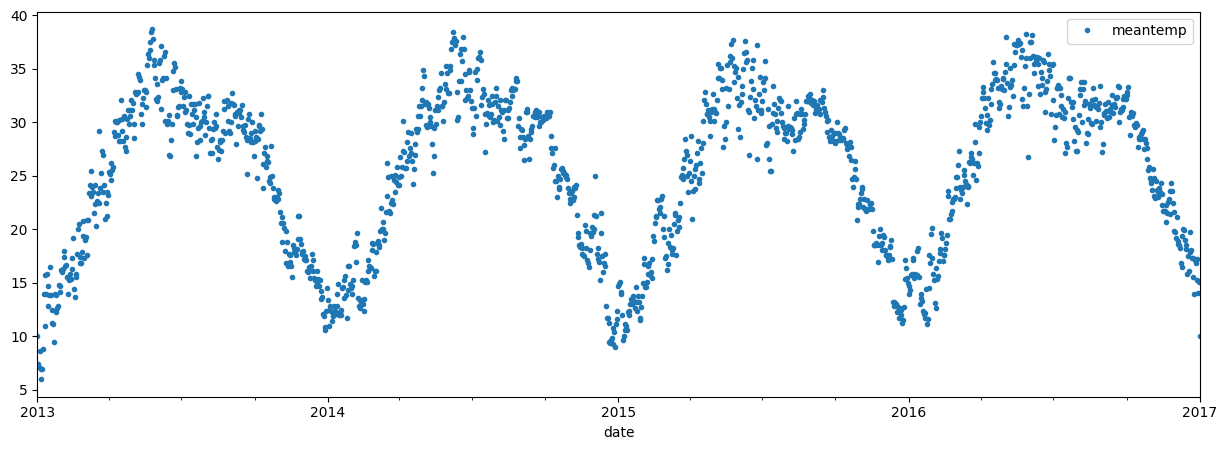

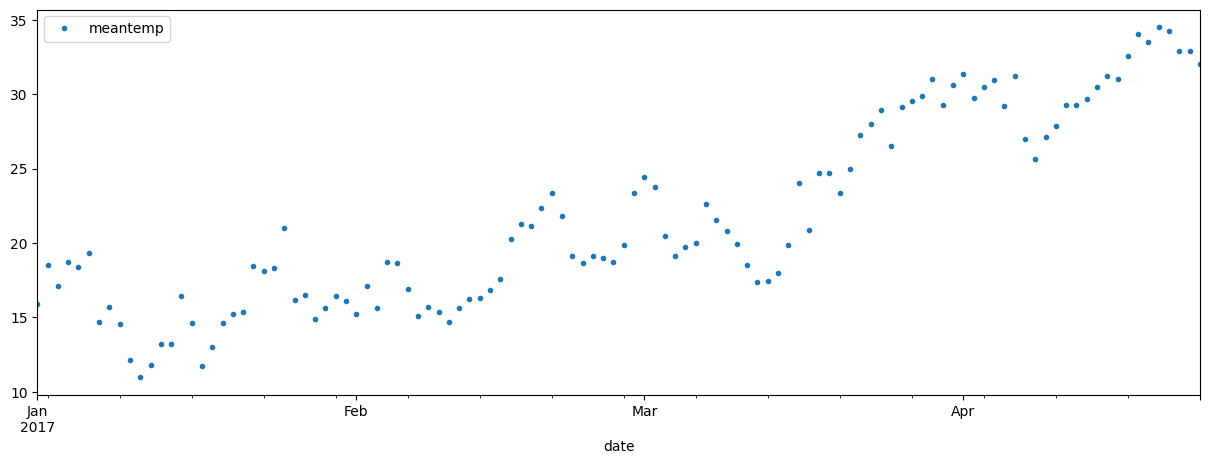

In [10]:
df.plot(y='meantemp', figsize=(15,5), style='.')
df_test.plot(y='meantemp', figsize=(15,5), style='.')

<AxesSubplot: xlabel='date'>

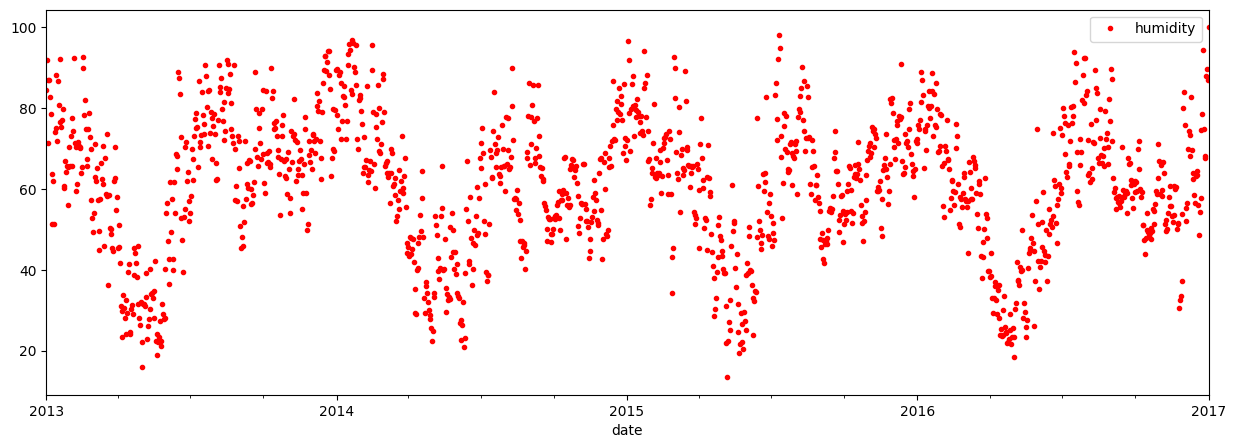

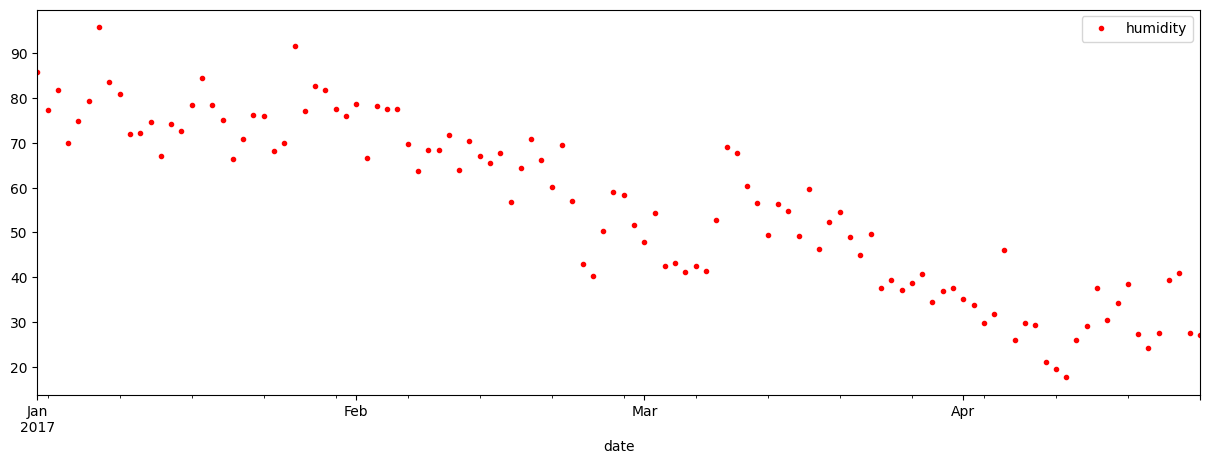

In [11]:
df.plot(y='humidity', figsize=(15,5), style='.', color='red')
df_test.plot(y='humidity', figsize=(15,5), style='.', color='red')

<AxesSubplot: xlabel='date'>

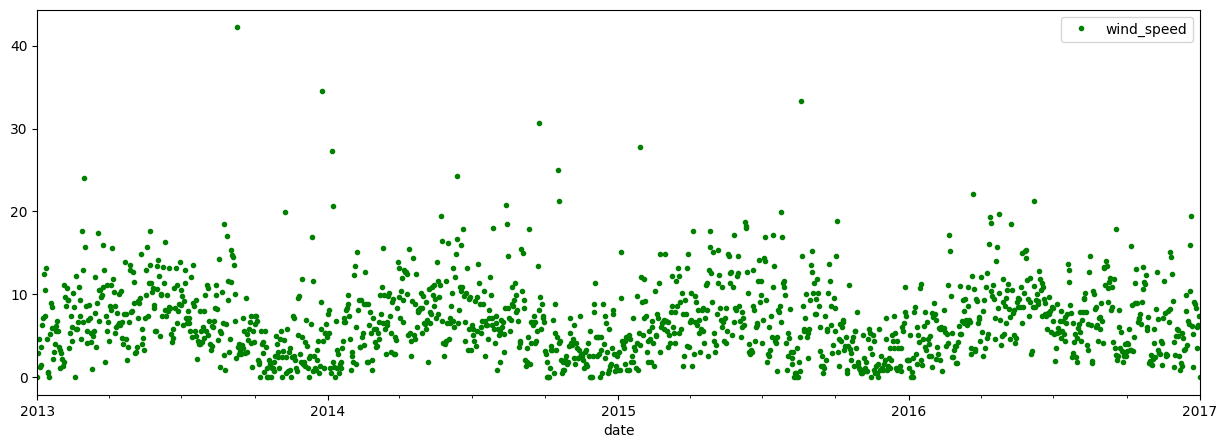

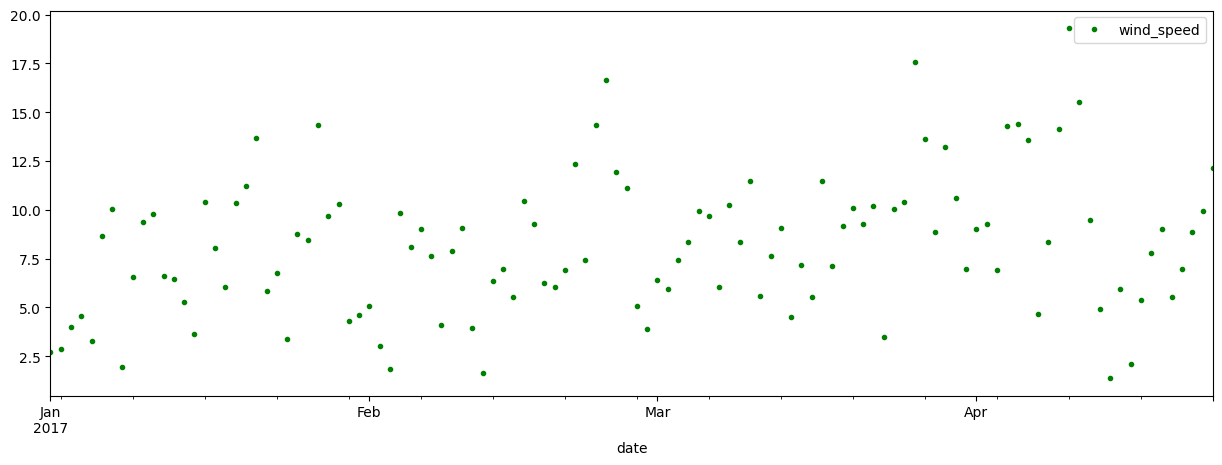

In [12]:
df.plot(y='wind_speed', figsize=(15,5), style='.', color='green')
df_test.plot(y='wind_speed', figsize=(15,5), style='.', color='green')

<AxesSubplot: xlabel='date'>

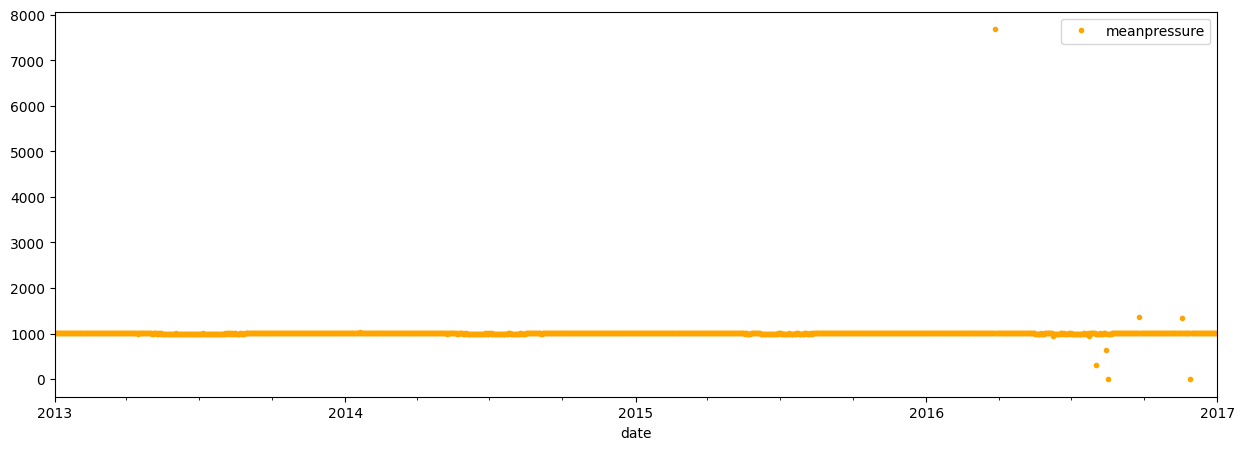

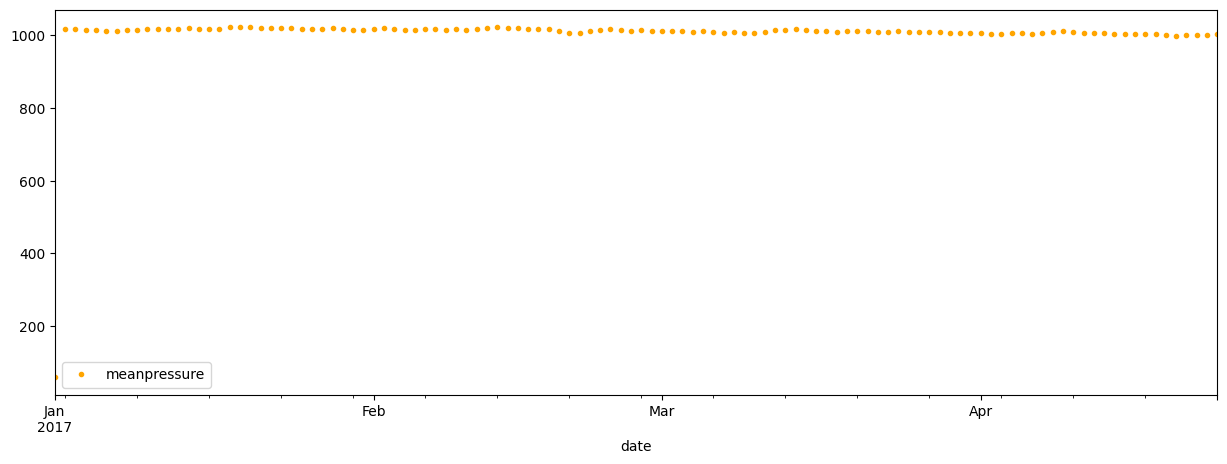

In [13]:
df.plot(y='meanpressure', figsize=(15,5), style='.', color='orange')
df_test.plot(y='meanpressure', figsize=(15,5), style='.', color='orange')

In [14]:
dfcp = df.copy()
dfcp['week'] = dfcp.index.isocalendar().week
dfcp['month'] = dfcp.index.month

dfcp_test = df_test.copy()
dfcp_test['week'] = dfcp_test.index.isocalendar().week
dfcp_test['month'] = dfcp_test.index.month
print(dfcp_test.head())

             meantemp   humidity  wind_speed  meanpressure  week  month
date                                                                   
2017-01-01  15.913043  85.869565    2.743478     59.000000    52      1
2017-01-02  18.500000  77.222222    2.894444   1018.277778     1      1
2017-01-03  17.111111  81.888889    4.016667   1018.333333     1      1
2017-01-04  18.700000  70.050000    4.545000   1015.700000     1      1
2017-01-05  18.388889  74.944444    3.300000   1014.333333     1      1


In [15]:
def get_train_test(features, target, train=dfcp, test=dfcp_test):
    train = train.copy()
    X_train = train.drop(columns=[target])
    y_train = train[target]

    test = test.copy()
    X_test = test.drop(columns=[target])
    y_test = test[target]

    X_train = X_train.astype(np.int64)
    X_test = X_test.astype(np.int64)

    return X_train, X_test, y_train, y_test

In [16]:
def visualise_preds(original_frame, pred_store, target):
    fig, ax = plt.subplots(figsize=(7, 5))
    pred_store.plot(ax=ax, y='XGBoost_pred', color='red')
    original_frame.plot(ax=ax, y=target)

In [17]:
def get_all_preds(models, X_test, model_names):
    pred_store = X_test.copy()
    all_preds = []
    for model, name in zip(models, model_names):
        pred = model.predict(X_test)
        pred_store[name] = pred

    return pred_store

In [18]:
# Method to get a trained XGboost model
from tabnanny import verbose

def train_XGBoost(X_train, X_test, y_train, y_test):
    model = xgb.XGBRegressor(n_estimators=5000,
                       early_stopping_rounds=100,
                       objective='reg:squarederror',
                       max_depth=4,
                       learning_rate=0.01,
                       )
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    return model

In [19]:
def determine_ARIMA_parameters(X_train, y_train):
    # Use to find differencing value for ARIMA
    plot_acf(y_train)
    print(f'p-value: ', adfuller(y_train)[1])
    plot_acf(y_train.diff())
    print(f'p-value: ', adfuller(y_train.diff().dropna())[1])
    plot_acf(y_train.diff().diff())
    print(f'p-value: ', adfuller(y_train.diff().diff().dropna())[1])

    # Use to find order value for ARIMA
    plot_pacf(y_train.diff())
    plot_pacf(y_train.diff().diff())

In [26]:
def train_ARIMA(X_train, y_train, y_test, X_test):
    # arima_model = ARIMA(X_train, order=(0,1,5))
    arima = pm.auto_arima(y_train,X=X_train, d=1,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=750,m=4,stationary=False,test='adf',seasonal=True)
    # model = arima_model.fit()
    pred=arima.predict(n_periods=114, X=X_test, alpha=0.05)
    print(len(pred))
    print(arima.summary())
    plt.figure(figsize=(7,5))
    plt.plot(pred)
    plt.plot(y_test)

In [21]:
# Method to get all trained models for the different target attributes
def train_models(features, targets, dfcp, dfcp_test):
    model_names = ['XGBoost_pred']

    for target in targets:
        models = []
        X_train, X_test, y_train, y_test = get_train_test(features, target, train=dfcp, test=dfcp_test)
        train_ARIMA(X_train, y_train, y_test, X_test)
        model = train_XGBoost(X_train, X_test, y_train, y_test)
        models.append(model)

        pred_store = get_all_preds(models, X_test, model_names)
        visualise_preds(dfcp_test, pred_store, target)
        models.append(model)
    
    return models

In [22]:
features = ['week', 'month','meantemp','humidity','wind_speed']
# targets = ['meantemp','humidity','wind_speed']
targets = ['meantemp','humidity','wind_speed']

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=4732.311, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=4813.593, Time=0.40 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=4813.806, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=4812.756, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=4811.602, Time=0.63 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=4729.966, Time=3.71 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=4728.058, Time=2.08 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=4730.417, Time=2.73 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=4733.599, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=4726.320, Time=5.74 sec
 ARIMA(2,1,1)(1,0,0)[4] intercept   : AIC=4727.780, Time=13.95 sec
 ARIMA(2,1,1)(0,0,1)[4] intercept   : AIC=4729.262, Time=7.30 sec
 ARIMA(2,1,1)(1,0,1)[4] intercept   : AIC=4730.940, Time=8.15 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=4818.932, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[4] intercep

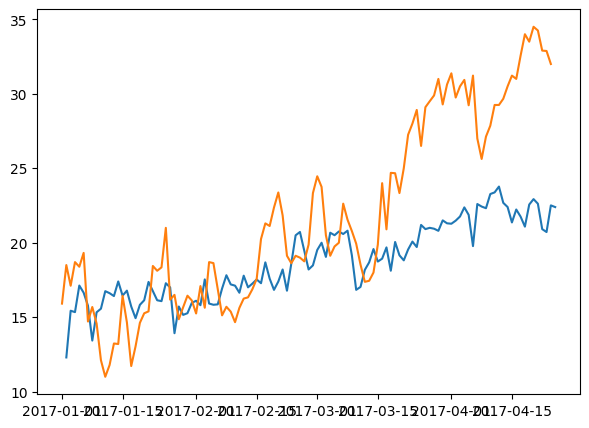

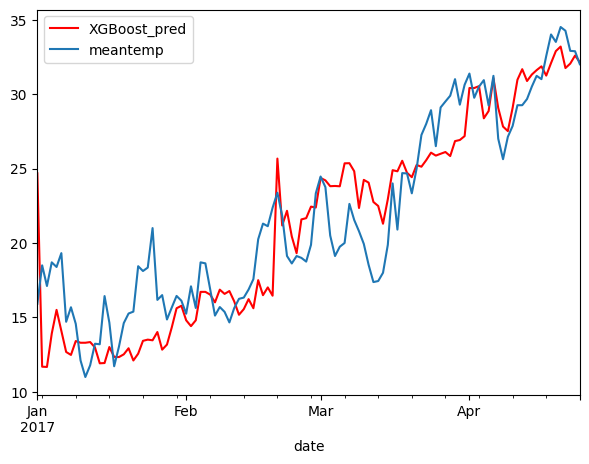

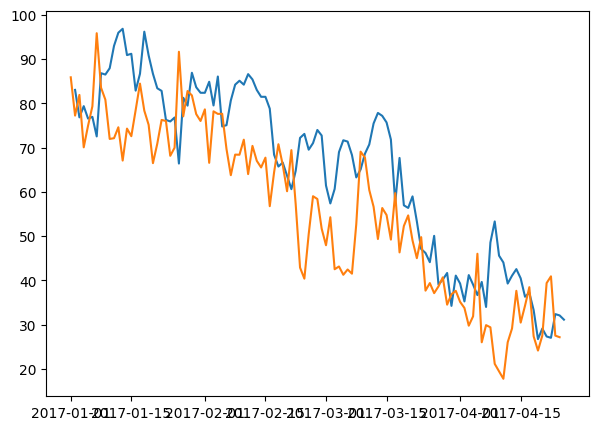

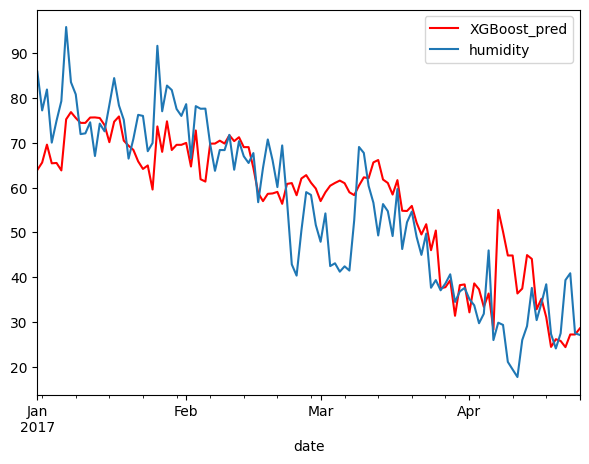

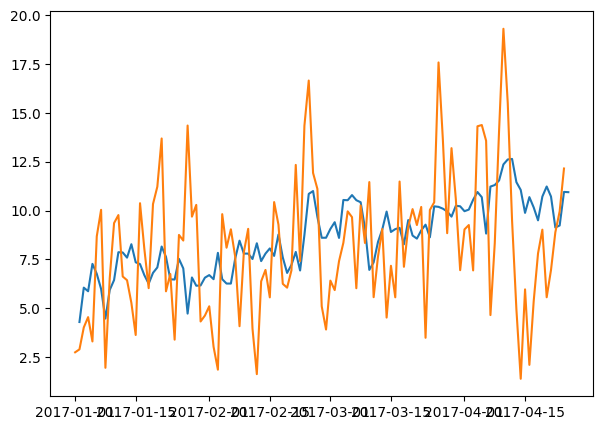

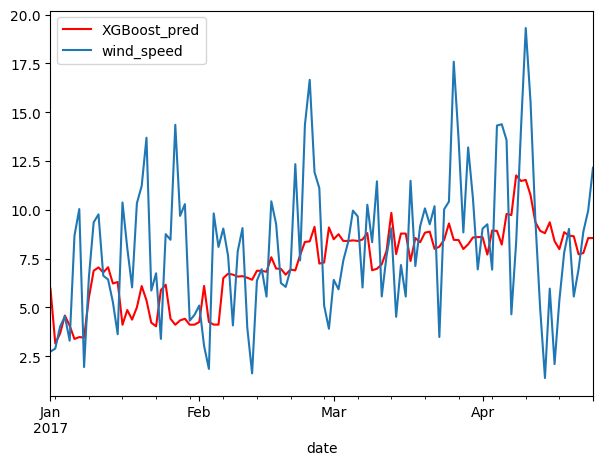

In [25]:
models = train_models(features, targets, dfcp, dfcp_test)